# Creating dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
DATADIR = '../datasets/Classification/Dataset - 3 dias/Images'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [3]:
def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            ## add images to training data with its label
            training_data.append([img_array, class_num])
    return training_data
            
training_data = create_training_data()
            

In [4]:
print(len(training_data))

1101


In [5]:
#mix data for better learning
import random
random.shuffle(training_data)

In [6]:
images = []
labels = []

for image, label in training_data:
    images.append(image)
    labels.append(label)

In [7]:
##saving dataset
import pickle
DATASET_PATH = "../datasets/Classification/Dataset - 3 dias/"

pickle_out = open(os.path.join(DATASET_PATH, "3_days_images.pickle"), "wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(DATASET_PATH, "3_days_labels.pickle"), "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()



# Creating classificatin model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os


#### Reading and preparing the dataset

In [9]:
import imutils
def pad_image(image, size_x, size_y):
    shape = image.shape
    res = []
    
    pad_image = np.zeros((size_x,size_y,3), np.uint8)
    
    if shape[0] > shape[1]:
        res = imutils.resize(image, height=size_x)
        res = center_image(res, pad_image)
    else:
        res = imutils.resize(image, width=size_y)
        res = center_image(res, pad_image)
    
    return res
    
def center_image(image, background):
    img_shape = image.shape
    bck_shape = background.shape
    
    x_diff = round((bck_shape[0] - img_shape[0])/2)
    y_diff = round((bck_shape[1] - img_shape[1])/2)
    
#     print(image.shape, background.shape, x_diff, y_diff)
    
    res = background.copy()
    
    res[x_diff:x_diff + img_shape[0],y_diff:y_diff + img_shape[1]] = image
    
    return res
        

In [10]:
images_raw = open(os.path.join(DATASET_PATH, "3_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "3_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

##### Padding Images in Memory

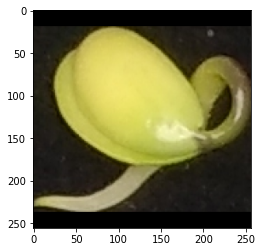

In [11]:
for i in range(len(images)):
    images[i] = pad_image(images[i], IMG_SIZE, IMG_SIZE)
    plt.imshow(images[i])

##### Labels one hot enconding

In [12]:
import pandas as pd

labels = pd.get_dummies(labels)
labels = pd.DataFrame.to_numpy(labels)

###### Train Test split

In [13]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [14]:
print(train_images.shape)

(880, 256, 256, 3)


##### Normalizing training images

In [15]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

#### Creating the model


In [38]:
EPOCHS = 30
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = round( (1 - TRAIN_TEST_SPLIT) * train_images.shape[0] / 32)
print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

660.0 21


In [60]:
model = Sequential()

model.add(   Conv2D(4, (3,3), input_shape=train_images.shape[1:])  )
model.add(Activation("relu"))
model.add(Dropout(0.2, input_shape=images.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(2, (2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(8))

model.add(Dense(3))
model.add(Activation("sigmoid"))


my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)

In [61]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT)

Epoch 1/30
32/32 [==============================] - 5s 142ms/step - loss: 59.3768 - accuracy: 0.5570 - precision_7: 0.4539 - recall_7: 0.4278 - auc_7: 0.5804 - true_positives_7: 155.1818 - true_negatives_7: 544.2121 - false_positives_7: 167.0606 - false_negatives_7: 200.4545 - val_loss: 35.6186 - val_accuracy: 0.6682 - val_precision_7: 0.6000 - val_recall_7: 0.5182 - val_auc_7: 0.6805 - val_true_positives_7: 114.0000 - val_true_negatives_7: 364.0000 - val_false_positives_7: 76.0000 - val_false_negatives_7: 106.0000
Epoch 2/30
32/32 [==============================] - 4s 126ms/step - loss: 25.1382 - accuracy: 0.7417 - precision_7: 0.6011 - recall_7: 0.4822 - auc_7: 0.6773 - true_positives_7: 172.7273 - true_negatives_7: 590.4545 - false_positives_7: 120.8182 - false_negatives_7: 182.9091 - val_loss: 28.0610 - val_accuracy: 0.6318 - val_precision_7: 0.5409 - val_recall_7: 0.5409 - val_auc_7: 0.6687 - val_true_positives_7: 119.0000 - val_true_negatives_7: 339.0000 - val_false_positives_7: 

Epoch 17/30
32/32 [==============================] - 4s 122ms/step - loss: 2.7533 - accuracy: 0.8039 - precision_7: 0.6053 - recall_7: 0.4786 - auc_7: 0.6773 - true_positives_7: 173.7273 - true_negatives_7: 592.4545 - false_positives_7: 118.8182 - false_negatives_7: 181.9091 - val_loss: 5.0997 - val_accuracy: 0.6727 - val_precision_7: 0.5622 - val_recall_7: 0.4727 - val_auc_7: 0.6596 - val_true_positives_7: 104.0000 - val_true_negatives_7: 359.0000 - val_false_positives_7: 81.0000 - val_false_negatives_7: 116.0000
Epoch 18/30
32/32 [==============================] - 4s 122ms/step - loss: 3.1135 - accuracy: 0.7861 - precision_7: 0.5960 - recall_7: 0.5242 - auc_7: 0.7001 - true_positives_7: 185.4545 - true_negatives_7: 584.5758 - false_positives_7: 126.6970 - false_negatives_7: 170.1818 - val_loss: 5.1704 - val_accuracy: 0.6955 - val_precision_7: 0.5253 - val_recall_7: 0.5182 - val_auc_7: 0.6516 - val_true_positives_7: 114.0000 - val_true_negatives_7: 337.0000 - val_false_positives_7: 10

In [63]:
model.evaluate(test_images, test_labels)

7/7 [==============================] - 0s 55ms/step - loss: 3.9975 - accuracy: 0.7240 - precision_7: 0.5284 - recall_7: 0.5475 - auc_7: 0.6902 - true_positives_7: 121.0000 - true_negatives_7: 334.0000 - false_positives_7: 108.0000 - false_negatives_7: 100.0000


[3.997530698776245,
 0.7239819169044495,
 0.528384268283844,
 0.5475113391876221,
 0.6902090311050415,
 121.0,
 334.0,
 108.0,
 100.0]

#### Visualizing model data

In [64]:
import matplotlib.pyplot as plt

In [65]:
NUM_METRICS = len(my_metrics)
METRICDIR = './metricas/classificacao/3_d/non_normalized/'
SAVE = False

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


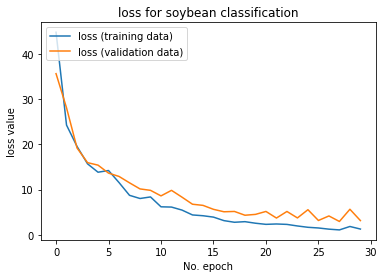

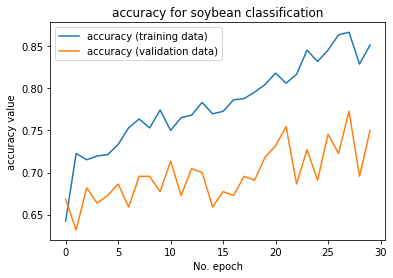

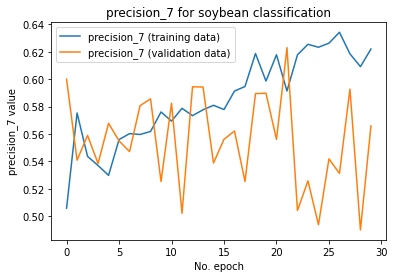

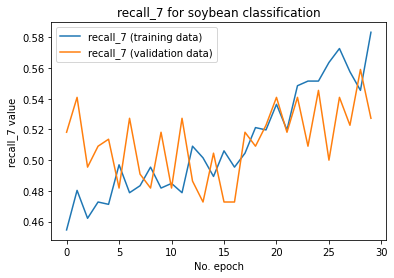

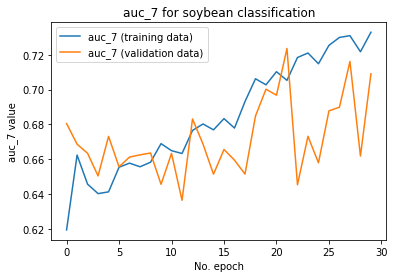

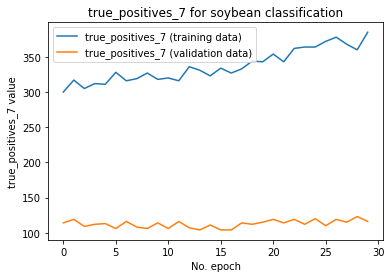

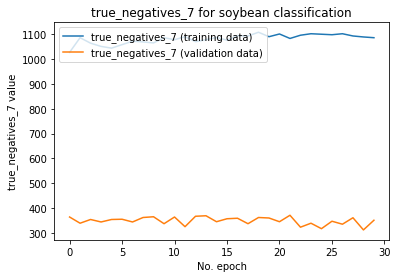

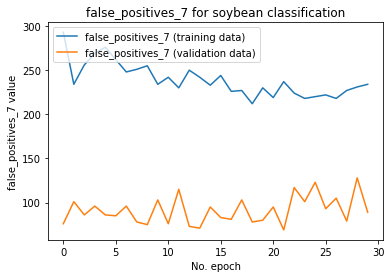

In [66]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")


In [29]:
MODELDIR = os.path.join(METRICDIR, "model")
if SAVE and not os.path.exists(MODELDIR):
    os.mkdir(MODELDIR)
model.save(MODELDIR)

INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/non_normalized/model/assets
